In [1]:
from sklearn.base import BaseEstimator, TransformerMixin
#from category_encoders.one_hot import OneHotEncoder
#from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import Imputer
#from category_encoders.ordinal import OrdinalEncoder

from __future__ import print_function
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD
from keras.constraints import maxnorm

import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import seaborn as sns

/Users/lsafari/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
class XCentralizer(BaseEstimator, TransformerMixin):
    
    def __init__(self, x_columns):
        self.x_columns = x_columns
        
    def fit(self, x, y = None):
        return self
    
    def transform(self, x): #x is df
        shift=x[["rightShoulder_x","leftShoulder_x","leftHip_x","rightHip_x"]].sum(axis=1)/4
        for col in self.x_columns:
            x[col] = x[col] - shift
        return x

class YCentralizer(BaseEstimator, TransformerMixin):
    
    def __init__(self, y_columns):
        self.y_columns = y_columns
        
    def fit(self, x, y = None):
        return self
    
    def transform(self, x): #x is df
        shift=x[["rightShoulder_y","leftShoulder_y","leftHip_y","rightHip_y"]].sum(axis=1)/4
        for col in list(set(self.y_columns)-set(["label"])):
            x[col] = x[col] - shift
        return x

class YScaler(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
        
    def fit(self, x, y = None):
        return self
    
    def transform(self, x): #x is df
        shoulder_y = x[["rightShoulder_y","leftShoulder_y"]].sum(axis=1)/2
        hip_y = x[["leftHip_y","rightHip_y"]].sum(axis=1)/2
        y_dist = hip_y - shoulder_y
        
        for col in list(set(x.columns)-set(["label"])):
            x[col] /= y_dist
        return x


### Inspect Train Data

In [3]:
!pwd

/Users/lsafari/drone_steering/models


In [4]:
#df = pd.read_csv("video_001.csv", delimiter=',')
# Christian's video is less noisy. Therefore I only train the model with his data at the moment. 
# acc increased 5 % taking his video camparing to all videos.
#path = "all_videos_posture_steptime50_checksum8160"
#path = "video_Christian_posture_steptime50_checksum8160"
path = "video_all_posture_steptime50_checksum8160"
df = pd.read_csv("/Users/lsafari/drone_steering/data/" + path + ".csv",low_memory=False)
#df=df.drop([5557], axis=0)
#type(df.leftShoulder_x)
#df.info()
df.head(3)

,leftShoulder_x,leftShoulder_y,rightShoulder_x,rightShoulder_y,leftElbow_x,leftElbow_y,rightElbow_x,rightElbow_y,leftWrist_x,leftWrist_y,rightWrist_x,rightWrist_y,leftHip_x,leftHip_y,rightHip_x,rightHip_y,label
0,0.49250,0.18750,0.4000,0.18250,0.5050,0.26000,0.34375,0.19500,0.50875,0.33875,0.26625,0.16875,0.46500,0.34375,0.41125,0.34625,1
1,0.49250,0.18875,0.4025,0.18625,0.5075,0.25875,0.33250,0.19750,0.50000,0.33750,0.27625,0.17500,0.46750,0.33625,0.40875,0.33750,1
2,0.49125,0.19000,0.4025,0.17875,0.5050,0.26125,0.33500,0.19875,0.51125,0.33500,0.26375,0.16875,0.46375,0.33875,0.40875,0.33750,1


In [5]:
#df[["leftShoulder_y","rightShoulder_y","leftHip_y","rightHip_y"]]
#df.describe()
#df.info()
#df.label.unique()
df.shape

(3837, 17)

In [6]:
#for i in df:
    #print(i, df[i].isnull().sum())    

In [7]:
df1=df.dropna().drop_duplicates()
#df1
#df1
df1.shape

(3719, 17)

In [8]:
# Checking that we don't have any null values
assert df1.isnull().all().all() == False

In [9]:
#df1.describe()

x=df1.copy()
#x=x.drop(["label"], axis = 1)
x_cols = ['leftShoulder_x', 'rightShoulder_x',
        'leftElbow_x', 'rightElbow_x',
        'leftWrist_x', 'rightWrist_x',
        'leftHip_x', 'rightHip_x']
xtrans = XCentralizer(x_cols)
x = xtrans.transform(x)

y_cols = list(set(x.columns)-set(x_cols))
#print(y_cols)
ytrans = YCentralizer(y_cols)
x = ytrans.transform(x)

ytrans = YScaler()
x = ytrans.transform(x)
x[:2]

,leftShoulder_x,leftShoulder_y,rightShoulder_x,rightShoulder_y,leftElbow_x,leftElbow_y,rightElbow_x,rightElbow_y,leftWrist_x,leftWrist_y,rightWrist_x,rightWrist_y,leftHip_x,leftHip_y,rightHip_x,rightHip_y,label
0,0.314453,-0.484375,-0.263672,-0.515625,0.392578,-0.031250,-0.615234,-0.437500,0.416016,0.460937,-1.099609,-0.601562,0.142578,0.492187,-0.193359,0.507812,1
1,0.332636,-0.491632,-0.269874,-0.508368,0.433054,-0.023013,-0.738494,-0.433054,0.382845,0.504184,-1.115063,-0.583682,0.165272,0.495816,-0.228033,0.504184,1


In [10]:
class Shuffler(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
        
    def fit(self, x, y = None):
        return self
    
    def transform(self, x): #x is df
        x=x.loc[np.random.permutation(x.index)]
        
        return x



In [11]:
shuff=Shuffler()

df_shuffled=shuff.transform(df1)

In [12]:

df_train = df_shuffled.iloc[:int(df_shuffled.shape[0]*0.8)]
df_val = df_shuffled.iloc[int(df_shuffled.shape[0]*0.8):]

In [13]:
y_train = df_train['label']
x_train = df_train.drop('label', axis = 1)

y_val = df_val['label']
x_val = df_val.drop('label', axis = 1)

In [14]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

x_train=x_train.values
y_train=y_train.values
x_val=x_val.values
y_val=y_val.values

x_train.shape, y_train.shape, x_val.shape, y_val.shape

#x_train
print("x_train=", x_train[0],"\n y_train=", y_train[0])

x_train= [0.53125 0.2175  0.44125 0.21625 0.5475  0.28875 0.42375 0.3     0.5475
 0.36625 0.4075  0.3575  0.51125 0.365   0.45375 0.37   ] 
 y_train= 4


# Visualize the Data

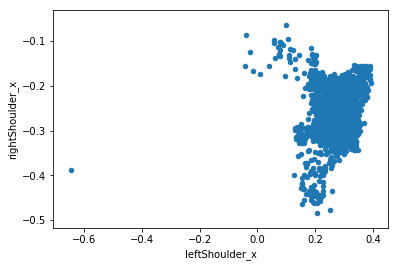

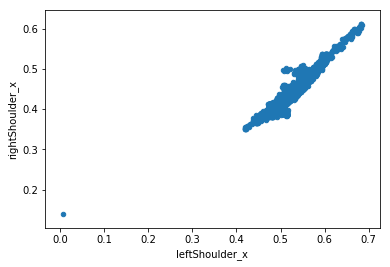

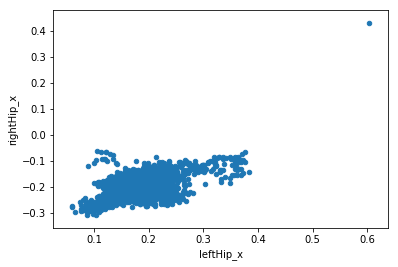

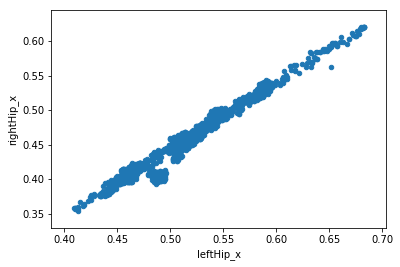

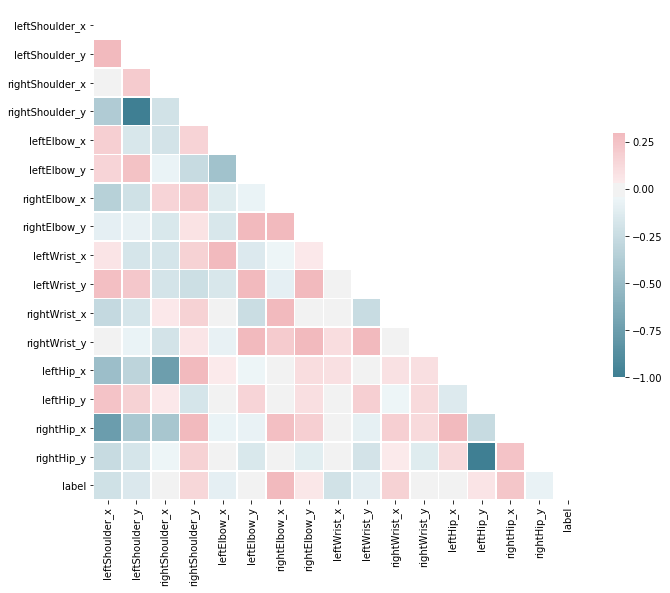

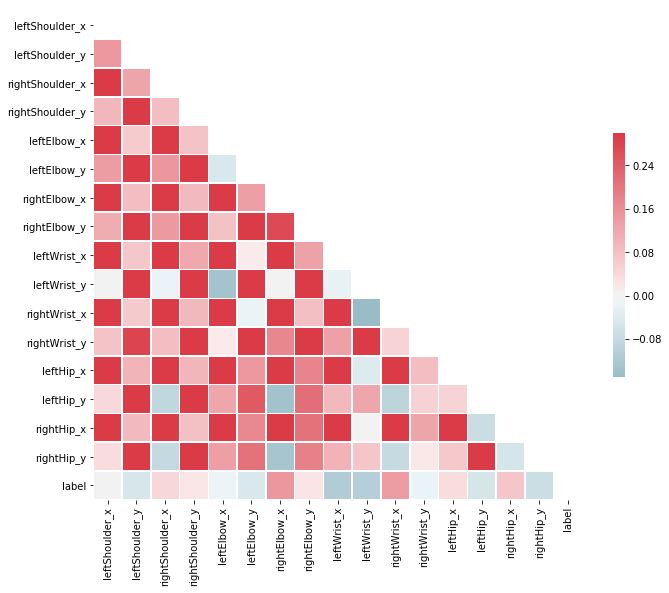

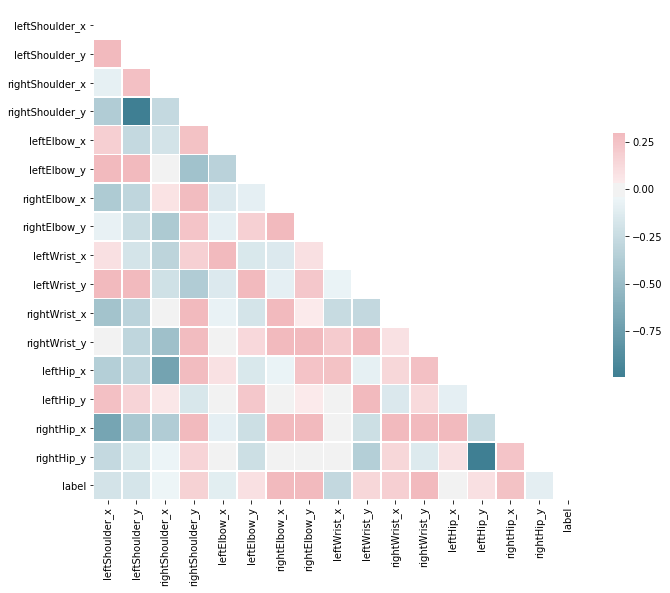

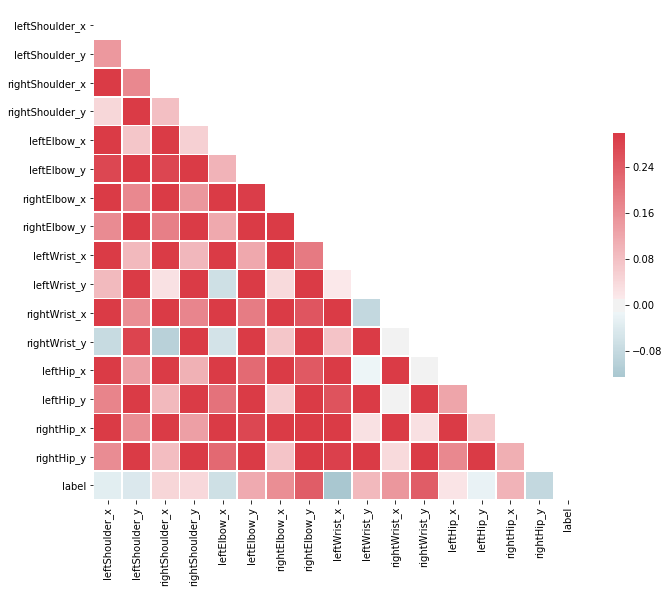

In [30]:
df1 = x
df1.plot('leftShoulder_x', 'rightShoulder_x', kind='scatter')
df.plot('leftShoulder_x', 'rightShoulder_x', kind='scatter')
df1.plot('leftHip_x', 'rightHip_x', kind='scatter')
df.plot('leftHip_x', 'rightHip_x', kind='scatter')
#df1.plot('rightShoulder_x', 'label', kind='scatter')
#df1.plot('rightHip_x', 'label', kind='scatter')
#df1.plot('leftHip_x', 'label', kind='scatter')

# Compute the correlation matrix
corr1_pearson = df1.corr(method='pearson')
corr1_spearman = df1.corr(method='spearman')

corr_pearson = df.corr(method='pearson')
corr_spearman = df.corr(method='spearman')

#################################################################

# Generate a mask for the upper triangle
mask = np.zeros_like(corr1_pearson, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr1_pearson, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#################################################################
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_pearson, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_pearson, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
#################################################################

# Generate a mask for the upper triangle
mask = np.zeros_like(corr1_spearman, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr1_spearman, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
#################################################################
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_spearman, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_spearman, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

df_shuffled = df1.loc[np.random.permutation(df1.index)]
df_train = df_shuffled.iloc[:int(df_shuffled.shape[0]*0.8)]
df_val = df_shuffled.iloc[int(df_shuffled.shape[0]*0.8):]